<a id="top"></a>
# Land Change

<hr>

> `If Fractional Cover is included in the analysis, this notebook will crash due to memory limitations. Only NDVI and EVI are currently supported`.

A notebook that demonstrates using Fractional Cover to detect vegetation change is available under the `Real_world_examples` folder: [Vegetation_change_detection](../../Real_world_examples/Vegetation_change_detection.ipynb). However, this notebook requires admin access as it uses USGS Provisional C2,L2 data.

# Notebook Summary

This notebook uses changes in NDVI or EVI to identify land change. 
The algorithm identifies a "baseline" and "analysis" time period and then compares 
the spectral parameters in each of those time periods. Significant reductions in 
vegetation are coincident with land change. In some cases these changes could be 
deforestation. Users of this algorithm should not accept the accuracy of the results 
but should conduct ground validation testing to assess accuracy. In most cases, these 
algorithms can be used to identify clusters of pixels that have experienced change and 
allow targeted investigation of those areas by local or regional governments.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Define Analysis Parameters](#define_analysis_params)
* [Load and Clean Data from the Data Cube](#load_data)
* [Calculate Spectral Indices and Fractional Cover](#calculate)
* [Show Threshold Image](#threshold)
* [Show Anomalies](#anomalies)
    * Show Spectral Anomaly Product
    * Show Threshold Spectral Anomaly Product
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Load Data Cube Configuration
import datacube
# Enable importing of utilities.
import sys
import os

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
import dask
from datacube.utils.dask import start_local_dask
from datacube.utils.rio import configure_s3_access
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from odc.ui import DcViewer
from datacube.helpers import write_geotiff
import datetime as dt

#import DE Africa script
sys.path.append('../../Scripts')
from deafrica_plotting import display_map, rgb
from deafrica_datahandling import load_masked_usgs, mostcommon_crs

#import DCAL utility scripts
sys.path.append('../DCAL_utils')
from plotter_utils import figure_ratio, retrieve_or_create_fig_ax, intersection_threshold_plot, month_names_long
from dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic, ls8_unpack_qa, ls7_unpack_qa 
from dc_time import _n64_to_datetime
from clean_mask import landsat_qa_clean_mask
# from dc_fractional_coverage_classifier import frac_coverage_classify


## Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell.

In [2]:
dask.config.set({"distributed.dashboard.link": 
        os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"})

client = start_local_dask(n_workers=4, threads_per_worker=1, memory_limit='3G')
display(client)

creds = configure_s3_access(client=client, 
                            region_name='auto')

Client Scheduler: tcp://127.0.0.1:46725 Dashboard: /user/cbur24/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 12.00 GB


## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**Visualize the available area**

In [3]:
dc = datacube.Datacube(app="DCAL Land Change")

In [4]:
# DcViewer(dc=dc,
#          products = ['ls8_usgs_sr_scene'],
#          time='2017',
#          center=(0.565, 38.007),
#          zoom=4)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select an analysis location 

# Mau Forest - Western Kenya
latitude = 0.02
longitude = 35.425

#size of analysis box in degrees (< 0.2 to keep memory use down)
buffer = 0.13

**Visualize the selected area**

In [6]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

## <span id="define_extents">Define the Temporal Extents of the Analysis [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = ('2014-01-01', '2014-12-31')

# Select the analysis time period (start and end)
analysis_time_period = ('2017-01-01', '2017-12-31')

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses
# HINT: Consider max_ndvi mosaics for NDVI analyses and median mosaics for EVI analyses 

baseline_mosaic_function = "median" 
analysis_mosaic_function = "median" 

## <span id="load_data">Load, Clean, and Mosaic Data from the Data Cube [&#9652;](#top)</span>

>#### Load Data (Baseline, Analysis) 

In [8]:
#create dictionary of common loading attributes
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'measurements': ["red", "green", "blue", "nir", "swir1", "swir2"],
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# find the right crs for the location
crs = mostcommon_crs(dc=dc,
                     product='ls8_usgs_sr_scene',
                     query=query)

# set the size of the dask chunks, this will determine how big each
# spatial chunk is that gets sent to each cpu during parallelization. 
chunks={'time': -1, 'x':250, 'y':250}

In [9]:
#load cloud masked data for baseline period
baseline_ds = load_masked_usgs(dc=dc, 
                      products=['ls8_usgs_sr_scene'], 
                      time = baseline_time_period,
                      dask_chunks = chunks,
                      lazy_load=True,
                      output_crs=crs,
                      align=(15, 15),
                      **query)

print(baseline_ds)

Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
    Applying pixel quality mask
Combining and sorting data
    Returning 40 observations as a dask array
<xarray.Dataset>
Dimensions:  (time: 40, x: 967, y: 960)
Coordinates:
  * y        (y) float64 1.659e+04 1.656e+04 1.653e+04 ... -1.215e+04 -1.218e+04
  * x        (x) float64 7.554e+05 7.555e+05 7.555e+05 ... 7.844e+05 7.844e+05
  * time     (time) datetime64[ns] 2014-01-09T07:50:14.620768 ... 2014-12-27T07:49:02.711517
Data variables:
    red      (time, y, x) float32 dask.array<shape=(40, 960, 967), chunksize=(40, 250, 250)>
    green    (time, y, x) float32 dask.array<shape=(40, 960, 967), chunksize=(40, 250, 250)>
    blue     (time, y, x) float32 dask.array<shape=(40, 960, 967), chunksize=(40, 250, 250)>
    nir      (time, y, x) float32 dask.array<shape=(40, 960, 967), chunksize=(40, 250, 250)>
    swir1    (time, y, x) float32 dask.array<shape=(40, 960, 967), chunksize=(40, 250, 250)>
   

In [10]:
#load cloud masked data for analysis period
analysis_ds = load_masked_usgs(dc=dc, 
                      products=['ls8_usgs_sr_scene'], 
                      time = analysis_time_period,
                      dask_chunks = chunks,
                      lazy_load=True,
                      output_crs=crs,
                      align=(15, 15),
                      **query)

print(analysis_ds)

Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
    Applying pixel quality mask
Combining and sorting data
    Returning 44 observations as a dask array
<xarray.Dataset>
Dimensions:  (time: 44, x: 967, y: 960)
Coordinates:
  * y        (y) float64 1.659e+04 1.656e+04 1.653e+04 ... -1.215e+04 -1.218e+04
  * x        (x) float64 7.554e+05 7.555e+05 7.555e+05 ... 7.844e+05 7.844e+05
  * time     (time) datetime64[ns] 2017-01-01T07:49:10.635621 ... 2017-12-26T07:55:19.785917
Data variables:
    red      (time, y, x) float32 dask.array<shape=(44, 960, 967), chunksize=(44, 250, 250)>
    green    (time, y, x) float32 dask.array<shape=(44, 960, 967), chunksize=(44, 250, 250)>
    blue     (time, y, x) float32 dask.array<shape=(44, 960, 967), chunksize=(44, 250, 250)>
    nir      (time, y, x) float32 dask.array<shape=(44, 960, 967), chunksize=(44, 250, 250)>
    swir1    (time, y, x) float32 dask.array<shape=(44, 960, 967), chunksize=(44, 250, 250)>
   

#### Rename 'x' and 'y' to 'latitude' and 'longitude' 

This is so the DE Africa data works with the DCAL util functions

In [11]:
#rename 'x', 'y' bands to 'latitude' and 'longitude'
baseline_ds = baseline_ds.rename(name_dict={'x':'longitude','y':'latitude'})
analysis_ds = analysis_ds.rename(name_dict={'x':'longitude','y':'latitude'})

### Compute dask arrays

we have to compute the dask arrays here because 'median' functions are not yet implemented with dask

In [12]:
baseline_ds = baseline_ds.compute()
analysis_ds = analysis_ds.compute()

### Mosaic timeseries

In [13]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [14]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

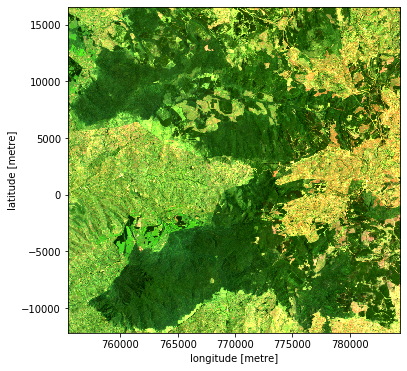

In [15]:
baseline_composite = baseline_compositor(baseline_ds)
rgb(baseline_composite)

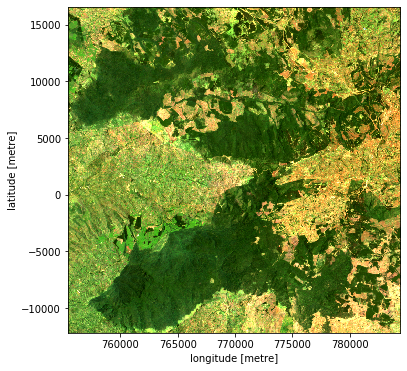

In [16]:
analysis_composite = analysis_compositor(analysis_ds)
rgb(analysis_composite)

## <span id="calculate">Calculate Spectral Indices and Fractional Cover [&#9652;](#top)</span>  

In [17]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [18]:
def EVI(ds, G=2.5, C1=6, C2=7.5, L=1, normalize=True):
    evi = G * (ds.nir - ds.red) / (ds.nir + C1 * ds.red - C2 * ds.blue + L)
    # Clamp values to the range [-1,2.5].
    evi.values[evi.values < -1] = -1
    evi.values[2.5 < evi.values] = 2.5
    if normalize:
        # Scale values in the  range [0,2.5] to the range [0,1].
        pos_vals_mask = 0 < evi.values
        evi.values[pos_vals_mask] = np.interp(evi.values[pos_vals_mask], (0, 2.5), (0,1))
    return evi

In [19]:
ndvi = NDVI(baseline_composite) 
evi = EVI(baseline_composite)

> Fractional Cover has been commented out to reduce memory usage. Only NDVI and EVI are currently supported

In [20]:
#change Coordinate names from x,y to Longitude, Latitude to be compatible with fractional cover module
# baseline_composite_frac = baseline_composite.rename(name_dict={'x':'longitude','y':'latitude'})

# frac_classes = frac_coverage_classify(baseline_composite_frac, clean_mask = np.ones(baseline_composite.pixel_qa.shape).astype(np.bool)) 

<p style="color:red";><b>CHANGE INPUTS BELOW

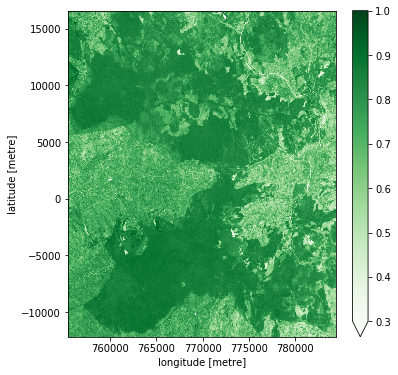

In [21]:
# Select a spectral index to plot by removing one of the comment tags (#) below.
# Only 1 of the plotting statements should be uncommented.
# Adjust the scale of the output using vmin and vmax.

(ndvi).plot(figsize=(6,6),cmap = "Greens", vmin=0.3, vmax=1.0)
# (evi).plot(figsize=(10,10),cmap = "Greens", vmin=0.3, vmax=1.0)
# (frac_classes.pv).plot(figsize=(10,10),cmap = "Greens", vmin=30.0, vmax=100.0)

plt.show()

## <span id="threshold">Show Threshold Image [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [22]:
# Select a baseline threshold range for a given parameter ... which is basically a "mask"
# The analysis will only consider pixels in this range for change detection
# No data or cloud pixels will also be masked in this process

# If you want to see all change, you should select the full range of values for each parameter
# NDVI full range = -1.0 to 1.0
# EVI full range = -1.0 to 1.0
# Fractional Cover full range = 0.0 to 100.0

# If you want to mask out everything but dense vegetation, typical of forested land, use the values below
# NDVI: 0.7 to 1.0
# EVI: 0.7 to 1.0
# Fractional Cover PV: 70.0 to 100.0

baseline_threshold_range = _min, _max = (0.7, 1.0) 

<p style="color:red";><b>CHANGE INPUTS BELOW

In [23]:
# Select the parameter to be used for thresholding ... NDVI, EVI or FC
# Remove the comment statement to use the desired parameter

baseline_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    
# baseline_filter_mask = np.logical_and(EVI(baseline_composite) > _min, EVI(baseline_composite) < _max)    
# baseline_filter_mask = np.logical_and(frac_classes.pv > _min, frac_classes.pv < _max)    

In [24]:
def aspect_ratio_helper(ds, fixed_width = 8):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [25]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

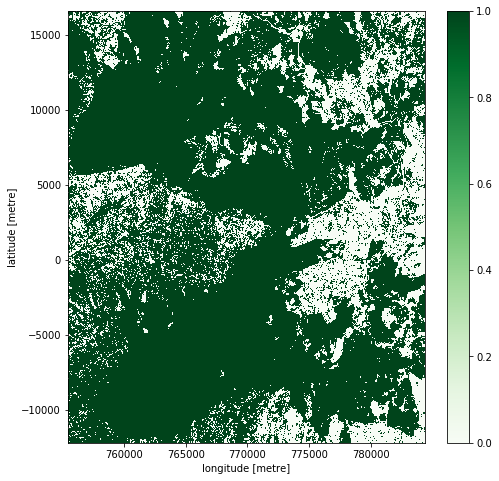

In [26]:
# This is the baseline threshold plot that shows GREEN pixels in the threshold range
# Pixels with values outside the threshold range are white 

plt.figure(figsize = aspect_ratio_helper(baseline_filter_mask)) 
baseline_filter_mask.plot(cmap = "Greens")
plt.show()

**Filter the baseline composite with the threshold mask.**

In [27]:
baseline_composite_filtered = baseline_composite.where(baseline_filter_mask)

## <span id="anomalies">Show Anomalies [&#9652;](#top)</span>  

### Show Spectral Anomaly Product

<p style="color:red";><b>CHANGE INPUTS BELOW

In [28]:
# Select the parameter to be used for the analysis
# You will select two lines for each parameter (baseline and analysis)

# Select these two lines for NDVI
parameter_baseline_composite = NDVI(baseline_composite_filtered)
parameter_analysis_composite = NDVI(analysis_composite)

# Select these two lines for EVI
# parameter_baseline_composite = EVI(baseline_composite_filtered)
# parameter_analysis_composite = EVI(analysis_composite)

# Select these two lines for Fractional Cover (FC)
# parameter_baseline_composite = frac_coverage_classify(baseline_composite_filtered, clean_mask = np.ones(baseline_composite_filtered.pixel_qa.shape).astype(np.bool)).pv
# parameter_analysis_composite = frac_coverage_classify(analysis_composite, clean_mask = np.ones(analysis_composite.pixel_qa.shape).astype(np.bool)).pv 

In [29]:
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

### Show Threshold Spectral Anomaly Product

<p style="color:red";><b>CHANGE INPUTS BELOW

In [30]:
# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# Losses are typically in these ranges for deforestation
# NDVI: -0.2 to -0.7
# EVI: -0.5 to -1.75
# Fractional Cover PV: -20 to -70

minimum_change = -0.2
maximum_change = -0.7


In [31]:
# Find regions that fall within min and max change
possibly_deforested = (parameter_anomaly < minimum_change) & (parameter_anomaly > maximum_change)

### Plot the results and inspect

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20),  sharex=True, sharey=True)

#baseline plots
(baseline_composite[['red', 'green', 'blue']]
 .to_array()
 .plot.imshow(ax=ax[0,0], robust=True))
#analysis plot
(analysis_composite[['red', 'green', 'blue']]
 .to_array()
 .plot.imshow(ax=ax[0,1], robust=True))
#anomaly plot
parameter_anomaly.plot(cmap = RdYlGn, ax=ax[1,0], add_colorbar=False)
#deforestation plot
possibly_deforested.where(possibly_deforested==1).plot(ax=ax[1,1], add_colorbar=False)

#titles
ax[0,0].set_title('Baseline composite')
ax[0,1].set_title('Analysis composite')
ax[1,0].set_title('Anomaly Map (analysis minus baseline)')
ax[1,1].set_title('Locations of possible deforestation')


Text(0.5, 1.0, 'Locations of possible deforestation')

In [ ]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
                    
    in_threshold = (da.values < min_threshold) & (da.values > max_threshold)
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.count_nonzero(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [ ]:
# This output is a count of the pixels that fall within each threshold range
threshold_count(parameter_anomaly, minimum_change,maximum_change)

In [ ]:
# This output is a percentage of the pixels that fall within each threshold range
threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>  

In [ ]:
#provide back the crs objects and rename bands to work with 'write_geotiff' function
baseline_composite = baseline_composite.rename(name_dict={'longitude':'x','latitude':'y'})
analysis_composite = analysis_composite.rename(name_dict={'longitude':'x','latitude':'y'})
parameter_anomaly = parameter_anomaly.to_dataset('parameter_anomaly').rename(name_dict={'longitude':'x','latitude':'y'})

baseline_composite.attrs['crs'] = crs
analysis_composite.attrs['crs'] = crs
parameter_anomaly.attrs['crs'] = crs

In [ ]:
#run command to save to files
write_geotiff("sample_baseline_01.tif", baseline_composite)
write_geotiff("sample_analysis_01.tif", analysis_composite)
write_geotiff("sample_anomaly_01.tif", parameter_anomaly)


## Notes on modifications made moving from ARDC to DE Africa

Commented out Fractional Cover analysis as it crashes the notebook due to memory limitations.  

Changes made
- Included dask in initial laoding of cloud-masked datasets
- Replace dc.load fuction with 'load_masked_usgs'
- Move all module imports to start of notebook
- Removed code to view extent of datacube replaced with mapviewer that can be used to visualise spatial extent of data
- Changed rgb plot fuction to DE Africa rgb plot fuction
- Simplified the plotting
- replaced save to geotiff function with DE Africa function
